# Divisive Clustering With Corsets Using CUDA-Q

This tutorial will explore a CUDA-Q implementation of recent research (ArXiv Paper: https://arxiv.org/pdf/2402.01529.pdf) performed by a team from the University of Edinburgh. This tutorial was jointly developed by NVIDIA and the authors so users can better understand their method and explore how CUDA-Q removed barriers to scaling. 

Clustering is a common unsupervised learning technique aimed at grouping data with similar characteristics. The unique properties of quantum computers could allow for enhanced pattern finding in clustering applications and enable more reliable data analysis. However, quantum computers today are severely limited by qubit count and noise.  Performing practical clustering applications would require far too many qubits.  The Edinburgh team developed a new method (extending the work of Harrow) to leverage corsets for clustering applications on quantum computers and use far fewer qubits.  This tutorial will walk through an example using this approach for divisive clustering and emphasize the utility of CUDA-Q for scaling quantum simulations.

The goal of divisive clustering is to begin with all data points as one set, and iteratively bipartition the data until each point is its own cluster.  The branching behavior of this process can be used to understand similarities in the data points.


In [1]:
!pip install -q -r requirements.txt

You should consider upgrading via the '/home/yogi/.pyenv/versions/3.10.0/envs/VQA-M/bin/python3.10 -m pip install --upgrade pip' command.


In [2]:
import cudaq
from cudaq import spin


# Auxillary Imports
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from typing import Tuple
from src.divisive_clustering import Coreset, DivisiveClustering, Dendrogram, Voironi_Tessalation

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

The settings below are global parameters for the quantum simulation and can be toggled by the user.  

In [3]:
circuit_depth = 1
max_iterations = 75
max_shots = 1000



Given a data set $X = (x_1, x_2, \cdots, x_N) $, a corset is weighted data set of much smaller size ($X', w$) that represents $X$ enough such that analysis of ($X', w$) can allow us to draw reasonable approximate conclusions about $X$. There are various approaches to build coresets. They can be found in Practical Coreset Construction for Machine Learning (https://arxiv.org/pdf/1703.06476.pdf) and New Streaming Algorithms for Coresets in Machine Learning (https://arxiv.org/pdf/1703.06476.pdf).


Essentially, coreset construction boils down to finding the optimal corset size and weights given some error tolerance.  Given the constraints of a quantum computer, in this work, a corset size is selected $a$ $priori$, and the error is determined for each model.


The following is an example $M=10$ corset constructed from a 1000-point data set and loaded into a pandas data frame. See the image below where the corset is represented by the black stars, the size of which corresponds to the weights.


In [4]:
raw_data = Coreset.create_dataset(1000)
coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)


coreset_vectors, coreset_weights = coreset.get_best_coresets()

coreset_df = pd.DataFrame(
    {"X": coreset_vectors[:, 0], "Y": coreset_vectors[:, 1], "weights": coreset_weights}
)
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
print(coreset_df)

Using BFL2 method to generate coresets
          X         Y     weights Name
0 -0.505513  0.508107  316.419461    A
1  7.030520  0.784114   98.069281    B
2  0.439667 -0.856466  226.854857    C
3  0.892147  0.366443   60.674169    D
4  8.140192  0.233876  117.715082    E
5  0.892147  0.366443   60.674169    F
6  5.951702  1.862087  156.590105    G
7  0.389014 -0.033655  151.414298    H
8  6.600641  3.083321   26.545935    I
9  0.744839 -0.364087  189.012689    J


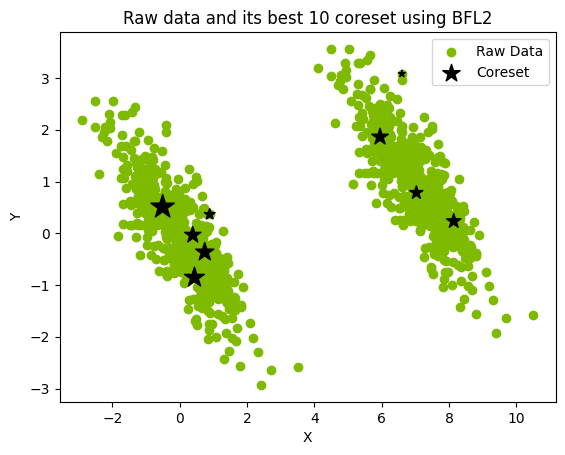

In [5]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], label="Raw Data", c="#7eba00")
plt.scatter(
    coreset_df["X"],
    coreset_df["Y"],
    s=coreset_df["weights"],
    label="Coreset",
    color="black",
    marker="*",
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best 10 coreset using BFL2")
plt.legend()
plt.show()

## Data preprocessing

In order to cluster data on a quantum computer, the task needs to be cast into the form of a binary optimization problem.  Each qubit represents a coreset point, and the quantum algorithm determines how to bipartition the coreset points at each iteration of the divisive clustering routine. 

The first step is to convert coreset points into a fully connected graph. The edge weight is calculated by:

$e_{ij} = w_iw_jd_{ij}$ where $d_{ij}$ is the Euclidian distance between points $i$ and $j$. 

This process is handled by `Coreset.corest_to_graph()`. The function returns a fully connected graph $G$ with edge weights.

## Quantum functions

The divisive clustering problem will be implemented on a quantum computer using a variational quantum algorithm (VQA) approach.  A VQA takes a Hamiltonian (encoded with the optimization problem) and a parameterized ansatz and evaluates expectation values (quantum computer) that inform updates to the ansatz parameters (classical computer).  The graph $G$ (Code in the "src" file)is used to construct the Hamiltonian, derived specifically for the divisive clustering problem, and motivated by a max-cut Hamiltonian.  The `spin.z(i)` method in CUDA-Q adds a Pauli Z operation that acts on qubit $i$ to the Hamiltonian.

In [6]:
def get_K2_Hamiltonian(G: nx.Graph) -> cudaq.SpinOperator:
    """Returns the K2 Hamiltonian for the given graph G

    Args:
        G (nx.Graph): Weighted graph
    """
    H = 0

    for i, j in G.edges():
        weight = G[i][j]["weight"]
        H += weight * (spin.z(i) * spin.z(j))

    return H

The code below constructs a quantum kernel, defining the circuit which will serve as an ansatz.  The structure of the circuit is a hardware efficient ansatz consisting of layers of parameterized $R_Z$ and $R_Y$ gate acting on each qubit, followed by a linear cascade of CNOT gates, and two more rotation gates.

The `@cudaq.kernel` decorator allows us to define a quantum circuit in the new kernel mode syntax which provides performance benefits to JIT compilation.

In [7]:
def get_VQE_circuit(number_of_qubits: int, circuit_depth: int) -> cudaq.Kernel:
    """Returns the VQE circuit for the given number of qubits and circuit depth

    Args:
        number_of_qubits (int): Number of qubits
        circuit_depth (int): Circuit depth

    Returns:
        cudaq.Kernel: VQE Circuit
    """

    @cudaq.kernel
    def kernel(thetas: list[float], number_of_qubits: int, circuit_depth: int):
        """VQE Circuit

        Args:
            thetas (list[float]): List of parameters
            number_of_qubits (int): Number of qubits
            circuit_depth (int): Circuit depth
        """
        qubits = cudaq.qvector(number_of_qubits)

        theta_position = 0

        for i in range(circuit_depth):
            for j in range(number_of_qubits):
                ry(thetas[theta_position], qubits[j])
                rz(thetas[theta_position + 1], qubits[j])

                theta_position += 2

            for j in range(number_of_qubits - 1):
                cx(qubits[j], qubits[j + 1])

            for j in range(number_of_qubits):
                ry(thetas[theta_position], qubits[j])
                rz(thetas[theta_position + 1], qubits[j])

                theta_position += 2

    return kernel

We can visualize the circuit using the `cudaq.draw()` method. Below, we are drawing the circuit for 5 qubits.

In [8]:
parameter_count = 4 * circuit_depth * 5
parameters = np.random.rand(parameter_count)

circuit = get_VQE_circuit(5, circuit_depth)
print(cudaq.draw(circuit, parameters, 5, circuit_depth))

     ╭────────────╮╭────────────╮     ╭────────────╮╭────────────╮»
q0 : ┤ ry(0.1353) ├┤ rz(0.2121) ├──●──┤ ry(0.6856) ├┤ rz(0.1637) ├»
     ├────────────┤╰┬──────────┬╯╭─┴─╮╰────────────╯├────────────┤»
q1 : ┤ ry(0.1227) ├─┤ rz(0.28) ├─┤ x ├──────●───────┤ ry(0.4057) ├»
     ├────────────┤╭┴──────────┴╮╰───╯    ╭─┴─╮     ╰────────────╯»
q2 : ┤ ry(0.1611) ├┤ rz(0.3397) ├─────────┤ x ├───────────●───────»
     ├────────────┤├────────────┤         ╰───╯         ╭─┴─╮     »
q3 : ┤ ry(0.1605) ├┤ rz(0.5678) ├───────────────────────┤ x ├─────»
     ├────────────┤├────────────┤                       ╰───╯     »
q4 : ┤ ry(0.8165) ├┤ rz(0.3752) ├─────────────────────────────────»
     ╰────────────╯╰────────────╯                                 »

################################################################################

                                          
──────────────────────────────────────────
╭────────────╮                            
┤ rz(0.7263) ├──────────────────────────

The next step is to select a classical optimizer. There are multiple [optimizers](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#optimizers) built-in to CUDA-Q that can be selected. The cde below returns the optimizer with the proper number of initial parameters. 

In [9]:
def get_optimizer(
    optimizer: cudaq.optimizers.optimizer, max_iterations, **kwargs
) -> Tuple[cudaq.optimizers.optimizer, int]:
    """Returns the optimizer with the given parameters

    Args:
        optimizer (cudaq.optimizers.optimizer): Optimizer
        max_iterations (int): Maximum number of iterations
        **kwargs: Additional arguments

    Returns:
        tuple(cudaq.optimizers.optimizer, int): Optimizer and parameter count
    """
    parameter_count = 4 * kwargs["circuit_depth"] * kwargs["qubits"]
    initial_params = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
    optimizer.initial_parameters = initial_params

    optimizer.max_iterations = max_iterations
    return optimizer, parameter_count

# Divisive Clustering Function

The `DivisiveClusteringVQA` class enables the procedure to iteratively bipartions the coreset points until each is its own cluster. If you wish to develop on top of this or see how the underlying code works, please see the `divisive_clustering.py` file in the src directory. 

`run_divisive_clustering`, takes the current iteration's coreset points that will be bipartitioned as inputs, extracts the appropriate weights and builds a graph $G$. The graph is then an input into the `get_counts_from_simulation` function. 


`get_counts_from_simulation` handles preparation and execution of the quantum simulation. First, it takes $G$ and from it builds a spin Hamiltonian. Second, it defines a cost function, which in this case is a lambda function that returns the expectation value of our parameterized quantum circuit and the Hamiltonian. This value is obtained using the CUDA-Q `observe` command, accelerated by GPUs.  After the expectation value is minimized, the quantum circuit corresponding to the optimal parameters is sampled using the CUDA-Q `sample` function. The bitstrings and their associated counts are returned by `get_counts_from_simulation`.

A subset of these counts is evaluated to compute their exact cost. The best bitstring is returned and later used to assign the coreste points to one of two clusters.


In [10]:
class DivisiveClusteringVQA(DivisiveClustering):
    def __init__(
        self,
        **kwargs,
    ):
        super().__init__(**kwargs)

    def run_divisive_clustering(
        self,
        coreset_vectors_df_for_iteration: pd.DataFrame,
    ):
        """Runs the Divisive Clustering algorithm

        Args:
            coreset_vectors_df_for_iteration (pd.DataFrame): Coreset vectors for the iteration

        Returns:
            str: Best bitstring

        """
        coreset_vectors_for_iteration_np, coreset_weights_for_iteration_np = (
            self._get_iteration_coreset_vectors_and_weights(coreset_vectors_df_for_iteration)
        )

        G = Coreset.coreset_to_graph(
            coreset_vectors_for_iteration_np,
            coreset_weights_for_iteration_np,
            metric=self.coreset_to_graph_metric,
        )

        counts = self.get_counts_from_simulation(
            G,
            self.circuit_depth,
            self.max_iterations,
            self.max_shots,
        )

        return self._get_best_bitstring(counts, G)

    def get_counts_from_simulation(
        self, G: nx.graph, circuit_depth: int, max_iterations: int, max_shots: int
    ) -> cudaq.SampleResult:
        """
        Runs the VQA simulation

        Args:
            G (nx.graph): Graph
            circuit_depth (int): Circuit depth
            max_iterations (int): Maximum number of iterations
            max_shots (int): Maximum number of shots

        Returns:
            cudaq.SampleResult: Measurement from the experiment
        """

        qubits = len(G.nodes)
        Hamiltonian = self.create_Hamiltonian(G)
        optimizer, parameter_count = self.optimizer_function(
            self.optimizer, max_iterations, qubits=qubits, circuit_depth=circuit_depth
        )

        kernel = self.create_circuit(qubits, circuit_depth)

        def objective_function(
            parameter_vector: list[float],
            hamiltonian: cudaq.SpinOperator = Hamiltonian,
            kernel: cudaq.Kernel = kernel,
        ) -> float:
            """

            Objective function that returns the cost of the simulation

            Args:
                parameter_vector (List[float]):
                hamiltonian (cudaq.SpinOperator): Circuit parameter values as a vector
                kernel (cudaq.Kernel) : Circuit configuration

            Returns:
                float: Expectation value of the circuit

            """

            get_result = lambda parameter_vector: cudaq.observe(
                kernel, hamiltonian, parameter_vector, qubits, circuit_depth
            ).expectation()

            cost = get_result(parameter_vector)

            return cost

        energy, optimal_parameters = optimizer.optimize(
            dimensions=parameter_count, function=objective_function
        )

        counts = cudaq.sample(
            kernel, optimal_parameters, qubits, circuit_depth, shots_count=max_shots
        )

        return counts

An instance of the `DivisiveClusteringVQA` class is mostly constructed from variables previously discussed like the functions for building the Hamiltonians and quantum circuits. Parameters related tot he quantum simulation can alsp be specified here such as `circuit_depth` and `max_shots`.  The ` threshold_for_max_cut` parameter specifies what percent of the sample results from the quantum computer are checked for the best bitstring value.

The other options specify advanced features like if the data is normalized and how the graph weights are computed.


Finally, the `get_divisive_sequence` method performas the iterations and produces the clustering data which we will analyze below. Note that this postprocessing code is not exposed int his tutorial but can be found in the source code. 


In [11]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer,
    create_circuit=get_VQE_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence = divisive_clustering.get_divisive_sequence(coreset_df)

100%|██████████| 1/1 [00:00<00:00, 2545.09it/s]


The data can be nicely visualized with a Dendrogram which maps where the bipartitionings occured. Early splits are generally mark divisions between the least like data.

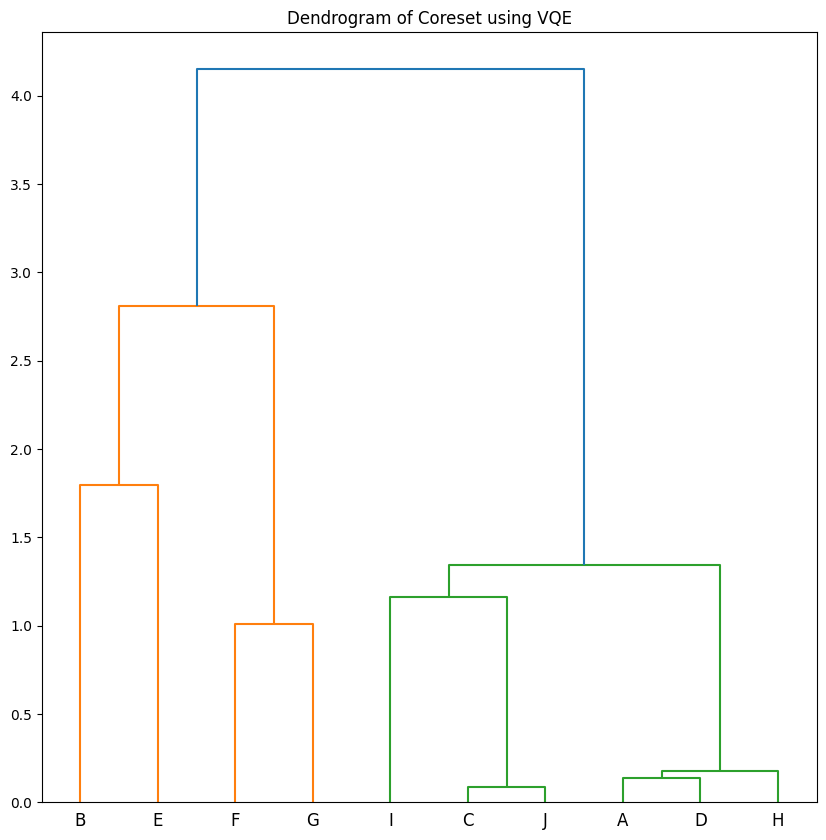

In [12]:
dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence)
dendo.plot_dendrogram(plot_title="Dendrogram of Coreset using VQE")

Each branch point in the dendrogram aboves corresponds to the one of the plots below. Notice the first iterations are the most complicated and the final iterations become trivial bipartitioning of two points. Occasionally, especially in the first iteration, the partitioning might be puzzling at first glance. The data might be seem to naturally cluster into two groups just by looking at it. However, there are cases where a stray point seems to belong in the wrong cluster.  There are two explanations for this.  1) The quantum sampling is approximate and stochastic. It is possible that too few shots were taken to samples the ground state of the problem. 2) It is important to remember that we are clustering coresets and not data points. There can be cases where it is optimal to pay a penalty by excluding a point based on proximity if the weights are small enough that the penalty has less impact. Usually, if a point looks unusually clustered and you go look at the original coresets plotted above, that point will have a small weight.

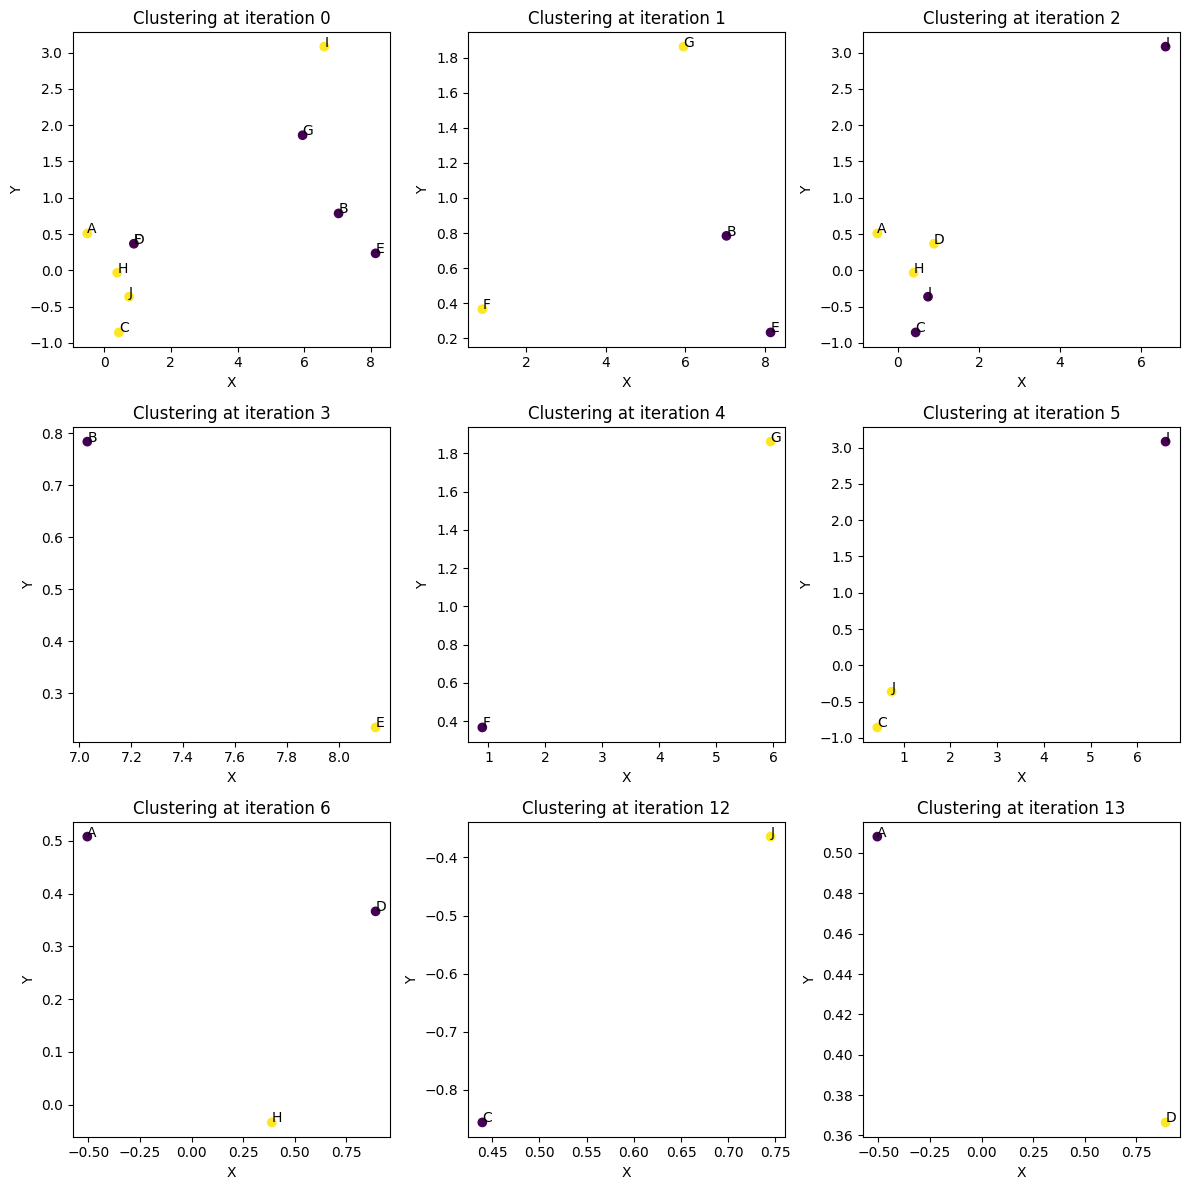

In [13]:
Dendrogram.plot_hierarchial_split(hierarchial_clustering_sequence, coreset_df)

The heirarchial clustering can be converted to flat clustering by drawing a line perpendicular to the branches. Any data point that intersects the line is considered to be in the same cluster. The function below performs this task at threshold height of 1.5. If you want to use the number of clusters instead of height, you can use `dendo.get_clusters_using_k()` method. You pass the number of desired clusters as an argument. Figure below shows the clusters that are formed at threshold height of 1.5.

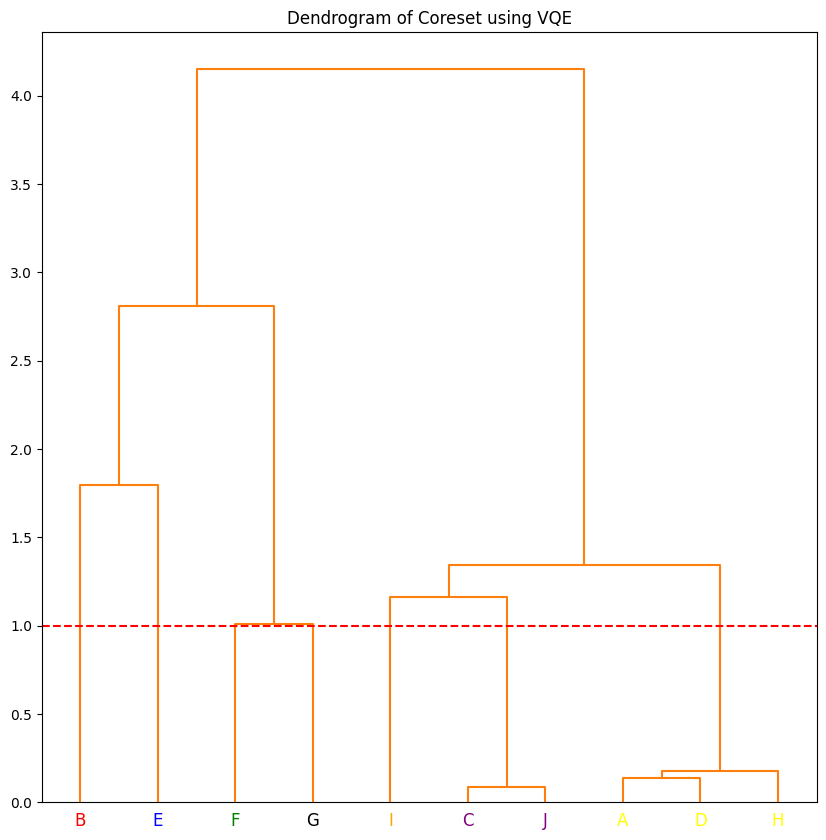

In [14]:
threshold_height = 1
clusters = dendo.get_clusters_using_height(threshold_height)
colors = ["red", "blue", "green", "black", "purple", "orange", "yellow"]
dendo.plot_dendrogram(
    plot_title="Dendrogram of Coreset using VQE",
    colors=colors,
    clusters=clusters,
    color_threshold=threshold_height,
)

You can visualize the flat clusters using `dendo.plot_clusters()` method. The function takes the clusters and colors as arguments. The clusters are represented by different colors.

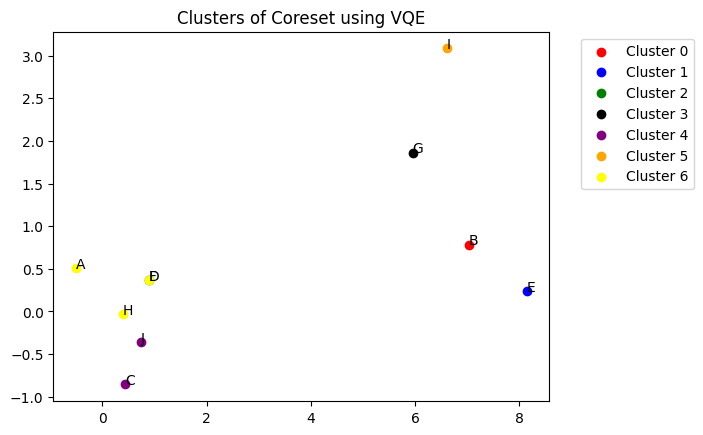

In [15]:
dendo.plot_clusters(
    clusters, colors, plot_title="Clusters of Coreset using VQE", show_annotation=True
)

The function below uses the `dendo.get_voronoi_tessalation()` method to convert the clusters into regions. `coreset_df`, `clusters` and `colors` need to be passed as the arguments to create the regions. This function creates a region for each coreset point separately and then colors them according to the clusters and colors passed as arguments. Another option is to create region using the centroids of the clusters. You need to pass `tesslation_by_cluster=True` to the function perform this task.

Once the region creation is complete, you can use `plot_voironi()` method to plot the regions. The function takes the clusters and colors as arguments. 

Remembering that these regions were based on coresets, they can then overly the original data set be used to cluster the data based on the coreset analysis.

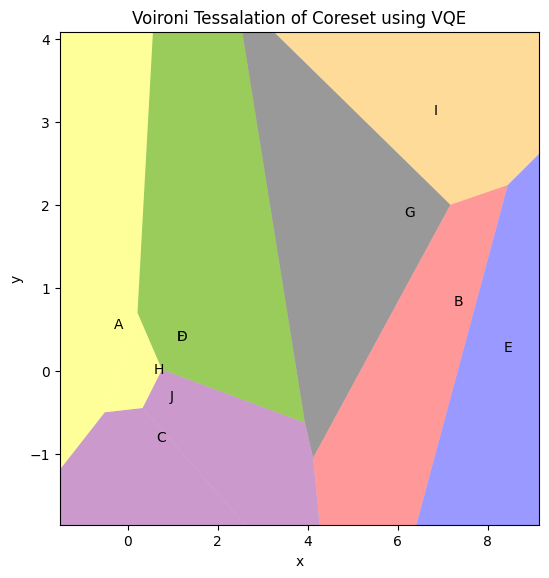

In [17]:
vt = Voironi_Tessalation(coreset_df, clusters, colors, tesslation_by_cluster=False)
vt.plot_voironi(plot_title="Voironi Tessalation of Coreset using VQE", show_annotation=True)

# QAOA Implementation

CUDA-Q is designed to be a flexible tools for developers so they can test different implementations of the same code. For example, one can perform the same analysis, instead using a QAOA approach. Only the kernel needs to be changed as is done below.

In [17]:
def get_QAOA_circuit(number_of_qubits, circuit_depth) -> cudaq.Kernel:
    """Returns the QAOA circuit for the given number of qubits and circuit depth


    Args:
        number_of_qubits (int): Number of qubits
        circuit_depth (int): Circuit depth

    Returns:
        cudaq.Kernel: QAOA Circuit
    """

    @cudaq.kernel
    def kernel(thetas: list[float], number_of_qubits: int, circuit_depth: int):
        qubits = cudaq.qvector(number_of_qubits)

        layers = circuit_depth

        for layer in range(layers):
            for qubit in range(number_of_qubits):
                cx(qubits[qubit], qubits[(qubit + 1) % number_of_qubits])
                rz(2.0 * thetas[layer], qubits[(qubit + 1) % number_of_qubits])
                cx(qubits[qubit], qubits[(qubit + 1) % number_of_qubits])

            rx(2.0 * thetas[layer + layers], qubits)

    return kernel


circuit = get_QAOA_circuit(5, circuit_depth)

print(cudaq.draw(circuit, np.random.rand(2 * circuit_depth), 5, circuit_depth))

                                                                          »
q0 : ──●─────────────────●────────────────────────────────────────────────»
     ╭─┴─╮╭───────────╮╭─┴─╮                                              »
q1 : ┤ x ├┤ rz(1.347) ├┤ x ├──●─────────────────●─────────────────────────»
     ╰───╯╰───────────╯╰───╯╭─┴─╮╭───────────╮╭─┴─╮                       »
q2 : ───────────────────────┤ x ├┤ rz(1.347) ├┤ x ├──●─────────────────●──»
                            ╰───╯╰───────────╯╰───╯╭─┴─╮╭───────────╮╭─┴─╮»
q3 : ──────────────────────────────────────────────┤ x ├┤ rz(1.347) ├┤ x ├»
                                                   ╰───╯╰───────────╯╰───╯»
q4 : ─────────────────────────────────────────────────────────────────────»
                                                                          »

################################################################################

                       ╭───╮╭───────────╮╭───╮╭─────────────╮
───────────────────

In [18]:
def get_optimizer(
    optimizer: cudaq.optimizers.optimizer, max_iterations, **kwargs
) -> Tuple[cudaq.optimizers.optimizer, int]:
    """
    Returns the optimizer with the given parameters

    Args:
        optimizer (cudaq.optimizers.optimizer): Optimizer
        max_iterations (int): Maximum number of iterations
        **kwargs: Additional arguments

    Returns:
        tuple(cudaq.optimizers.optimizer, int): Optimizer and parameter count
    """

    parameter_count = 2 * kwargs["circuit_depth"]
    optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
    optimizer.max_iterations = max_iterations
    return optimizer, parameter_count

In [19]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer,
    create_circuit=get_QAOA_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence = divisive_clustering.get_divisive_sequence(coreset_df)

100%|██████████| 4/4 [00:00<00:00, 23596.65it/s]


# Scaling simulations with CUDA-Q




The University of Edinburgh team quickly encountered scaling challenges when they were developing this method. By developing with CUDA-Q they were able to port their code to an HPC environment once GPUs became available. GPUs massively accelerated their development and testing and allowed them to produce the 25 qubit experiments presented in their publication. If you have a GPU available, run the following code examples and see how the times compare on your device. Each call executes the divisive clustering procedure using the QAOA method, 100000 simulated shots for each VQE loop, and maximum 75 VQE iterations.

First, try a slightly larger N=18 problem using the CPU (`qpp-cpu`) backend.

In [3]:
!python main_divisive_clustering.py --target qpp-cpu --M 18

Using BFL2 method to generate coresets
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 52758.54it/s]
Total time for the execution: 8950.935576847
Total time spent on CUDA-Q: 8933.615500671998


Now try the N=18 example on the GPU backend (`nvidia`).

In [2]:
!python main_divisive_clustering.py --target nvidia --M 18

Using BFL2 method to generate coresets
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 53773.13it/s]
Total time for the execution: 125.552444316
Total time spent on CUDA-Q: 11.683787750000008


Scaling up to N=25, the task becomes even more onerous on a CPU. Depending on your device, the simulation may not even run. Try it and feel free to interrupt after your patience has worn out.

In [10]:
# target = 'qpp-cpu'
!python main_divisive_clustering.py --target qpp-cpu --M 25

^C
 CTRL-C caught in cudaq runtime.


N=25 can still easily be completed by a single GPU.

In [4]:
# target = 'nvidia'
!python main_divisive_clustering.py --target nvidia --M 25

Using BFL2 method to generate coresets
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 47127.01it/s]
Total time for the execution: 67.61674502899999
Total time spent on CUDA-Q: 21.439895901


If we want to push the simulation to an $N=34$ corset, a single GPU (assuming A100) will run out of memory.  They the code below to see for yourself. 

In [7]:
# target = 'nvidia'
!python main_divisive_clustering.py --target nvidia --M 34

Using BFL2 method to generate coresets
RuntimeError: NLOpt runtime error: nlopt failure


To compute a problem with 34 qubits, we need to pool the memory of multiple GPUs.  If you have multiple GPUs available, try the code below to run the same computation on 4 GPUs. You do not need to wait for the code to finish, just note how it does not fail immediately due to memory issues.

In [9]:
# target = 'nvidia-mgpu'
!mpirun -np 4 python main_divisive_clustering.py --target nvidia-mgpu --M 34

Using BFL2 method to generate coresets
Using BFL2 method to generate coresets
Using BFL2 method to generate coresets
Using BFL2 method to generate coresets
^C
